1. Imports & Installs

In [5]:
!pip install pandas_datareader
!pip install matplotlib
!pip install tensorflow
!pip install scikit-learn

In [7]:
#
from pandas_datareader import data #used to fetch financial data from onilne resources
import matplotlib.pyplot as plt #visualize data
import pandas as pd #data manipulation library
import datetime as dt #for dates and time
import urllib.request, json #to fetch apis online & processing JSON files
import os #for read/write files
import numpy as np #math 
import tensorflow as tf #ML & NN This code has been tested with TensorFlow 1.6
from sklearn.preprocessing import MinMaxScaler #data manipulation

2. Data Processing

In [8]:
#load data
df = pd.read_csv(os.path.join('/Users/mihokoda/Desktop/Github/Stock Market//hpq.us.txt'), usecols=['Date','Open','High','Low','Close','Volume','OpenInt'])

In [9]:
df = df.sort_values('Date')
df.head()

,Date,Open,High,Low,Close,Volume,OpenInt
0,1970-01-02,0.30627,0.30627,0.30627,0.30627,2441124,0
1,1970-01-05,0.30627,0.31768,0.30627,0.31385,6219848,0
2,1970-01-06,0.31385,0.31385,0.30996,0.30996,4447522,0
3,1970-01-07,0.31385,0.31385,0.31385,0.31385,1872638,0
4,1970-01-08,0.31385,0.31768,0.31385,0.31385,4280330,0


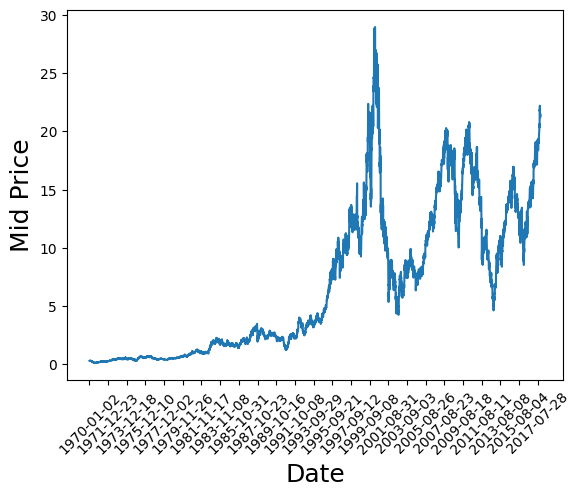

In [10]:
#plotting mid price vs date 
plt.plot(range(df.shape[0]), (df['Low']+df['High'])/2)
plt.xticks(range(0, df.shape[0], 500), df['Date'].loc[::500], rotation=45)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Mid Price', fontsize=18);

3. Splitting Data

In [11]:
high_prices = df.loc[:, 'High'].to_numpy()
low_prices = df.loc[:, 'Low'].to_numpy()
mid_prices = high_prices+low_prices/2

In [12]:
#splitting data
train_data = mid_prices[:11000]
test_data = mid_prices[11000:]
train_data = train_data.reshape(-1,1)
test_data = test_data.reshape(-1,1)

4. Normalizing
MinMaxScalar scales all the data to be in the region of 0 and 1.

In [14]:
#From the graph, different time periods of data have different value ranges.We normalize the data by splitting the full series into windows. 
#If you don't do this, the earlier data will be too close to 0 and will not add much value to the learning process. Here you choose a window size of 2500.

#normalizing training data
scaler = MinMaxScaler()
smoothing_window_size = 2500
for initial in range(0, 10000, smoothing_window_size):
    scaler.fit(train_data[initial:initial+smoothing_window_size]) #this internally updates scalar of the min and max of the input
    train_data[initial:initial+smoothing_window_size] = scaler.transform(train_data[initial:initial+smoothing_window_size])
scaler.fit(train_data[10000:])
train_data[10000:] = scaler.transform(train_data[10000:])
train_data = train_data.reshape(-1)

#normalizing testing data
scaler.fit(test_data)
test_data = scaler.transform(test_data).reshape(-1)

In [15]:
print(train_data)
print(test_data)

[0.31231743 0.324895   0.32270688 ... 0.38699382 0.38362895 0.37530965]
[0.17370142 0.17739544 0.1723735  ... 0.93887228 0.93331917 0.92873181]


In [16]:
#smooth the data using the exponential moving average. This helps you to get rid of the inherent raggedness of the data in stock prices and produce a smoother curve.
alpha = 0.1
EMA = 0
for i in range(11000):
    EMA = alpha * train_data[i] + (1-alpha)* EMA
    train_data[i] = EMA

all_mid_data = np.concatenate([train_data,test_data],axis=0)

1. Standard Average

In [17]:
window_size = 100
mean = []
mse = []
for index in range(window_size, 11000):
   mean.append(np.mean(train_data[index-window_size:index])) #predict t+1, we average from t-window to t
   mse.append((mean[-1]-train_data[index])**2) #calculate the mse of prediction and observed

print((0.5*np.mean(mse)))


0.00417898263705806


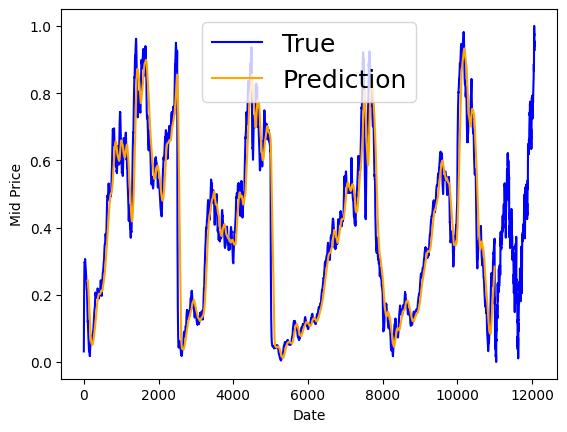

In [18]:
#visualizting our prediction: ps. this is lowkey fine lmao
plt.plot(range(df.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(window_size,11000),mean,color='orange',label='Prediction')
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

2. Exponential Moving Average


In [19]:
window_size = 100
alpha = 0.5
EMA = 0
predicted = []
mse = []
for i in range(1, 11000):
    EMA = alpha * train_data[i-1] + (1-alpha)* EMA
    predicted.append(EMA)
    mse.append((EMA-train_data[i])**2)

print((0.5*np.mean(mse)))




2.7382462880173755e-05


In [20]:
print(len(mse))
print(df.shape[0])

10999
12075


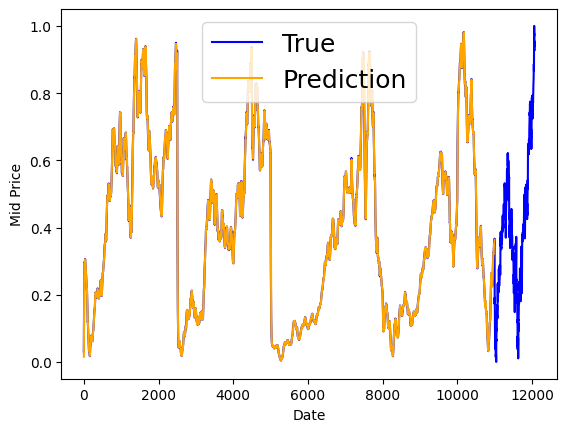

In [21]:
#visualizting our prediction
plt.plot(range(df.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(0, len(predicted)),predicted,color='orange',label='Prediction')
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()
#it's not that there's no blue from 0 -10000, it's just that it's so good they're the same line. 

3. LSTM

In [22]:

class DataGeneratorSeq(object):
    #每组batch_size个，一共num_unroll个组
    def __init__(self,prices,batch_size,num_unroll):
        self._prices = prices
        self._prices_length = len(self._prices) - num_unroll
        self._batch_size = batch_size
        self._num_unroll = num_unroll
        self._segments = self._prices_length //self._batch_size
        self._cursor = [offset * self._segments for offset in range(self._batch_size)]

    def next_batch(self):
        #create 1 组

        #initialize output
        batch_data = np.zeros((self._batch_size),dtype=np.float32)
        batch_labels = np.zeros((self._batch_size),dtype=np.float32)

        for b in range(self._batch_size):
            if self._cursor[b]+1>=self._prices_length:
                #self._cursor[b] = b * self._segments
                self._cursor[b] = np.random.randint(0,(b+1)*self._segments)


            batch_data[b] = self._prices[self._cursor[b]]
            batch_labels[b]= self._prices[self._cursor[b]+np.random.randint(0,5)]

            self._cursor[b] = (self._cursor[b]+1)%self._prices_length

        return batch_data,batch_labels    

   
    def unroll_batches(self):
        #create unroll_labels 组
        unroll_data,unroll_labels = [],[]
        for ui in range(self._num_unroll):

            data, labels = self.next_batch()    

            unroll_data.append(data)
            unroll_labels.append(labels)

        return np.stack(unroll_data).T, np.stack(unroll_labels).T  # Transpose to align to [batch_size, num_unroll]
        #return unroll_data, unroll_labels

    def reset_indices(self):
        for b in range(self._batch_size):
            self._cursor[b] = np.random.randint(0,min((b+1)*self._segments,self._prices_length-1))

"\ndg = DataGeneratorSeq(train_data,5,5)\nu_data, u_labels = dg.unroll_batches()\n\nfor ui,(dat,lbl) in enumerate(zip(u_data,u_labels)):   \n    print('\n\nUnrolled index %d'%ui)\n    dat_ind = dat\n    lbl_ind = lbl\n    print('\tInputs: ',dat )\n    print('\n\tOutput:',lbl)"

In [23]:
#hyperparameters
D = 1 # Dimensionality of the data. Since your data is 1-D this would be 1
num_unrollings = 50 # Number of time steps you look into the future.
batch_size = 500 # Number of samples in a batch
num_nodes = [200,200,150] # Number of hidden nodes in each layer of the deep LSTM stack we're using
n_layers = len(num_nodes) # number of layers
dropout = 0.2 # dropout amount



In [24]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(num_unrollings, D)),
        tf.keras.layers.LSTM(num_nodes[0], return_sequences=True, stateful=False),
        tf.keras.layers.Dropout(dropout),
        tf.keras.layers.LSTM(num_nodes[1], return_sequences=True, stateful=False),
        tf.keras.layers.Dropout(dropout),
        tf.keras.layers.LSTM(num_nodes[2], return_sequences=False, stateful=False),
        tf.keras.layers.Dropout(dropout),
        tf.keras.layers.Dense(1)
    ])
    return model

In [25]:
model = build_model()
model.compile(optimizer='adam', loss='mse')


/Users/mihokoda/Desktop/Github/Stock Market/sm/lib/python3.9/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [26]:
generator = DataGeneratorSeq(train_data, batch_size, num_unrollings)


In [33]:
epochs = 30
epoch_mses = []
epoch_losses = []

# epoch represents one complete pass through the entire training dataset
for epoch in range(epochs):    
    # Call the reset_indices method to randomize the starting point of data generation.
    # This helps in reducing the model's memorization of the sequence order, introducing stochasticity.
    generator.reset_indices()  # Resetting indices at the start of each epoch
    total_loss = 0
    mse_metric = tf.keras.metrics.MeanSquaredError()
    
    for step in range(len(train_data) // batch_size):
        # Generate a batch of input and output data:
        x_batch, y_batch = generator.unroll_batches()
        
        # Reshape `x_batch` to have three dimensions [batch_size, num_unrollings, D]
        x_batch = np.expand_dims(x_batch, axis=2)  # Expanding dimensions to match input shape requirements
        
        #updates the model's weights using the data from that batch only
        loss = model.train_on_batch(x_batch, y_batch)
        total_loss += loss
        mse_metric.update_state(y_batch, model.predict_on_batch(x_batch))
    
    average_loss = total_loss/(len(train_data) // batch_size)
    epoch_losses.append(average_loss)
    average_epoch_mse = mse_metric.result().numpy()
    epoch_mses.append(average_epoch_mse)

    print("Epoch {}/{}".format(epoch + 1, epochs))
    print("Average loss on this is: ", average_loss)
    print("Average mse on this is: ", average_epoch_mse)



Epoch 1/30
Average loss on this is:  0.0033660455797375603
Average mse on this is:  0.001901081
Epoch 2/30
Average loss on this is:  0.003332699426788498
Average mse on this is:  0.0017679303
Epoch 3/30
Average loss on this is:  0.0033018013928085566
Average mse on this is:  0.0019622082
Epoch 4/30
Average loss on this is:  0.0032771198205988517
Average mse on this is:  0.0020420777
Epoch 5/30
Average loss on this is:  0.0032561746933920817
Average mse on this is:  0.0019457671
Epoch 6/30
Average loss on this is:  0.003231157125397162
Average mse on this is:  0.0018898248
Epoch 7/30
Average loss on this is:  0.0032076789912852373
Average mse on this is:  0.0017927596
Epoch 8/30
Average loss on this is:  0.0031833889449692583
Average mse on this is:  0.0018412393
Epoch 9/30
Average loss on this is:  0.003160971862433309
Average mse on this is:  0.0018390483
Epoch 10/30
Average loss on this is:  0.003137020944533023
Average mse on this is:  0.0016926801
Epoch 11/30
Average loss on this i

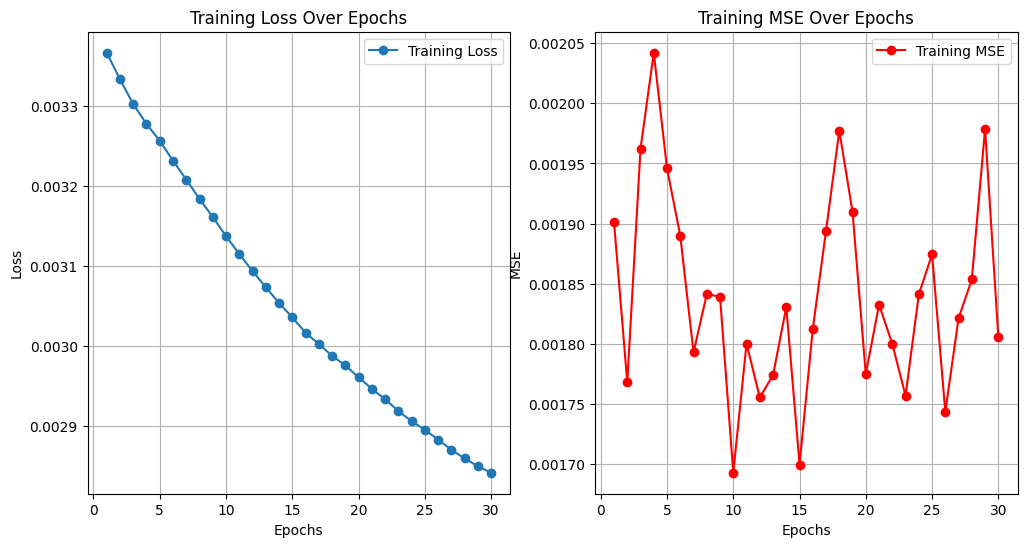

In [34]:
# Plotting the loss and MSE over epochs
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), epoch_losses, marker='o', label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), epoch_mses, marker='o', color='r', label='Training MSE')
plt.title('Training MSE Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)

In [37]:
def create_test_sequences(data, num_unrollings, D):
    """
    Create test sequences from the provided data, matching the input shape expected by the model.
    
    Args:
    data (array-like): The 1D array of test data.
    num_unrollings (int): The number of time steps per input sequence.
    D (int): The number of features per time step (1 for univariate data).
    
    Returns:
    array: The reshaped input data suitable for the model.
    """
    num_samples = len(data) - num_unrollings + 1
    x=_test = np.zeros((num_samples, num_unrollings, D))
    for i in range(num_samples):
        x_test[i] = data[i:i+num_unrollings].reshape(-1, D)
    return x_test

# Assuming 'test_data' is your numpy array of test inputs
x_test = create_test_sequences(test_data, num_unrollings, D)



In [38]:
y_pred = model.predict(x_test)


33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step


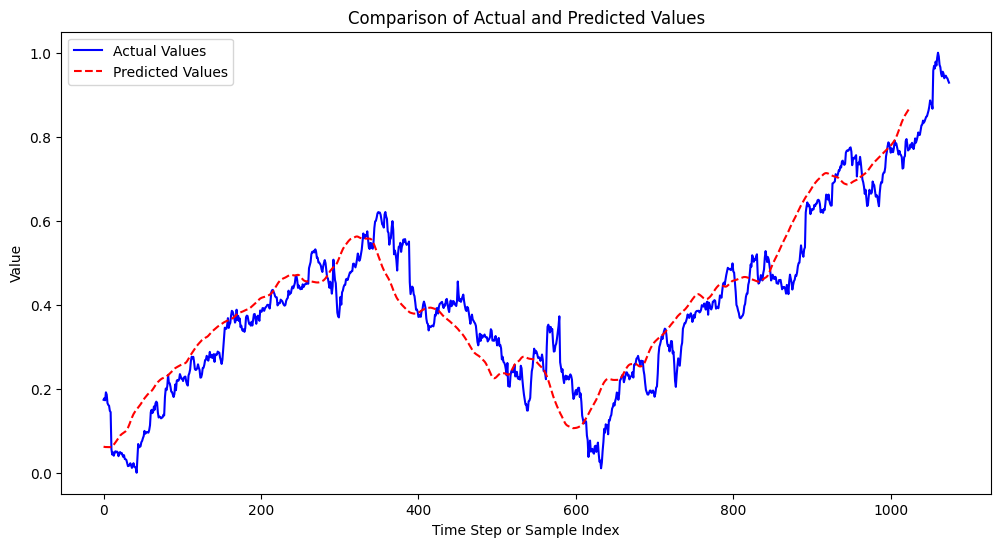

In [41]:
actual_length = len(test_data) - num_unrollings + 1  # This must match how y_pred is structured
plt.figure(figsize=(12, 6))
plt.plot(test_data, label='Actual Values', color='blue')  # Adjust indexing if needed
plt.plot(y_pred, label='Predicted Values', color='red', linestyle='--')
plt.title('Comparison of Actual and Predicted Values')
plt.xlabel('Time Step or Sample Index')
plt.ylabel('Value')
plt.legend()
plt.show()